In [1]:
import os
import joblib
import cv2
import warnings
import numpy as np
import pandas as pd
from PIL import Image
from mtcnn import MTCNN
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import to_categorical

# Suppress all warnings
warnings.filterwarnings("ignore")

Face Detection

(We first crop out the face, save it to another folder, and then send that face image to the model)

In [2]:
def detect_faces_in_folder(input_folder, output_folder):
    # Check if the output folder exists, create it if not
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # MTCNN detector
    detector = MTCNN()

    # Loop through each image file in the input folder
    for image_file in os.listdir(input_folder):
        image_path = os.path.join(input_folder, image_file)

        # Reading the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Unable to read {image_path}. Skipping...")
            continue
        
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Detect faces in the image
        faces = detector.detect_faces(image_rgb)

        # Loop through each detected face
        for idx, face in enumerate(faces):
            bounding_box = face['box']
            x, y, w, h = bounding_box

            min_face_size = 45
            if w > min_face_size and h > min_face_size:
                extracted_face = image[y:y + h, x:x + w]

                # Construct the path to store the extracted face image
                extracted_face_filename = f'{image_file.split(".")[0]}_face_{idx}.jpg'
                extracted_face_path = os.path.join(output_folder, extracted_face_filename)

                # Write the extracted face image to the output folder
                cv2.imwrite(extracted_face_path, extracted_face)
                print(f"Face Extraction Completed for {image_file}!")
            else:
                print(f"Face in {image_file} is too small and will be skipped.")

# Folders
input_folder = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\A_testing\\input_image'
output_folder = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\A_testing\\face_resized'

detect_faces_in_folder(input_folder, output_folder)


1/1 [==============================] - 0s 136ms/step
Face Extraction Completed for 1.JPG!


Predicting Skintone (lighting conditions) (LIGHTING MODEL DON'T WORK BETTER UMER)

1/1 [==============================] - 1s 1s/step


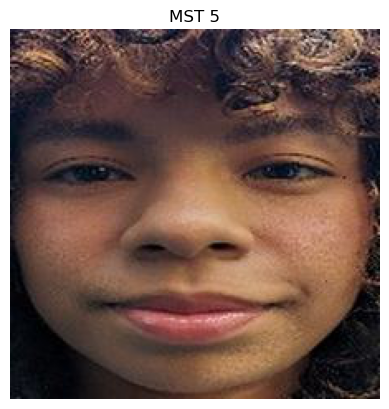


Predicted Skintone: MST 5


In [15]:
# # Function to predict skintone using the model
# def predict_skintone(model, folder_path, lighting_text, classes):

#     # Get list of image files in the folder path
#     image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
#     folder_path = os.path.join(folder_path, image_files[0])

#     # Preprocessing Image
#     image = Image.open(folder_path)
#     image = image.resize((224, 224))  
#     image = np.array(image) / 255.0  
#     image = np.expand_dims(image, axis=0) 

#     # Convert lighting text to one-hot encoding
#     lighting_encoded = classes.index(lighting_text)
#     lighting_onehot = to_categorical(lighting_encoded, num_classes=3)

#     #Predictions
#     prediction = model.predict({'image_input': image, 
#                                  'text_input': np.expand_dims(lighting_onehot, axis=0)})
#     skintone = np.argmax(prediction) + 1

#     # Display the image with the title "Modeling Hot"
#     plt.imshow(image[0])
#     plt.title(f"MST {skintone}")
#     plt.axis('off')
#     plt.show()

#     return skintone

# # Inputs required
# model = tf.keras.models.load_model('E:\\University\\FYP Stuff\\Models For SkinTone Recognition\\Skintone_Recognition_Multimodal1.h5')
# classes = ['poorly', 'video', 'well']
# lighting_text = 'poorly'
# folder_path = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\A_testing\\face_resized'

# skintone = predict_skintone(model, folder_path, lighting_text, classes)
# print("\nPredicted Skintone: MST",skintone)

Predicting Skintone (no Lighting conditions)

1/1 [==============================] - 1s 631ms/step


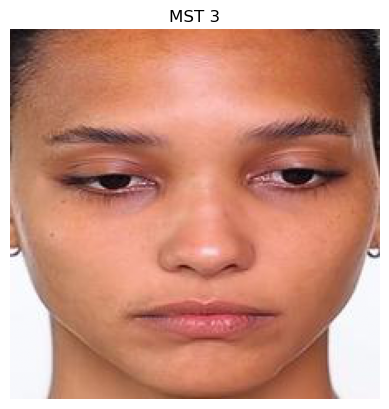


Predicted Skintone: MST 3


In [21]:
# Function to predict skintone using the model
def predict_skintone(model, folder_path, lighting_conditions):
    # Get list of image files in the folder path
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
    
    # Take the first image file for prediction
    image_path = os.path.join(folder_path, image_files[0])

    # Preprocess the image
    image = Image.open(image_path)
    image = image.resize((224, 224))  
    image = np.array(image) / 255.0  
    image = np.expand_dims(image, axis=0) 

    # Make predictions
    prediction = model.predict(image)
    skintone = np.argmax(prediction) + 1

    #Jugaari tareeka to incorporate light
    # #Consider Lighting Conditions
    # if (lighting_conditions == 'well'):
    #     skintone = skintone + 1
    # elif (lighting_conditions == 'poor'):
    #     skintone = skintone
    
    # Display the image
    plt.imshow(image[0])
    plt.title(f"MST {skintone}")
    plt.axis('off')
    plt.show()

    return skintone

# Load the model
model = tf.keras.models.load_model('E:\\University\\FYP Stuff\\Models For SkinTone Recognition\\Skintone_Recognition_2.h5')
folder_path = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\A_testing\\face_resized'
lighting_conditions = 'poor'

skintone = predict_skintone(model, folder_path, lighting_conditions)
print("\nPredicted Skintone: MST", skintone)

Predicting Makeup

In [23]:
# dataset
data = pd.read_excel('E:\\University\\FYP Stuff\\Dataset\\Youtube_Dataset_Final.xlsx')

# Load model
model = joblib.load('E:\\University\\FYP Stuff\\Models For SkinTone Recognition\\Makeup_Recommender.joblib')

def find_makeup_by_skintone(skintone, tolerance=0.1):
    # Predict the decimal makeup value based on the given skintone
    predicted_decimal_value = model.predict(np.array(skintone).reshape(-1, 1))[0]  # Extract the single value
    
    # Define the range of decimal values based on the tolerance
    decimal_min = predicted_decimal_value - tolerance
    decimal_max = predicted_decimal_value + tolerance
    
    # Filter the DataFrame based on the predicted decimal value range
    filtered_data = data[(data['foundationColorCode'] >= decimal_min) & (data['foundationColorCode'] <= decimal_max)]

    print(f"Recommended Products for MST {skintone}:\n")
    
    # Print the filtered DataFrame with only three specified columns
    print(filtered_data[['cosmeticBrand', 'cosmeticShade', 'productLink']])

find_makeup_by_skintone(skintone, tolerance=100000) #Tolerance level is showing the range of makeup(of that hexcode)

Recommended Products for MST 3:

        cosmeticBrand    cosmeticShade  \
1              Revlon   True Beige-320   
4           Too Faced    Natural Beige   
8                NARS      Valencia-M5   
69           Shiseido        350 Maple   
84          Too Faced             Nude   
98   MAKE UP FOR EVER  1Y16 warm beige   
100              Dior          4W warm   
102             INOUI          color 1   

                                           productLink  
1    http://https://www.revlon.com/face/foundation/...  
4    http://https://www.toofaced.com/product/23475/...  
8    http://https://www.narscosmetics.com/USA/sheer...  
69   http://https://www.sephora.com/product/shiseid...  
84   http://https://www.sephora.com/product/born-th...  
98   http://https://www.sephora.com/product/make-up...  
100  http://https://www.ulta.com/p/dior-forever-flu...  
102  http://https://beautygypsyrecommends.com/produ...  
